In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore")

In [ ]:
no_tumor_dir = '/content/drive/MyDrive/brain/train/no'
yes_tumor_dir = '/content/drive/MyDrive/brain/train/yes'

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images

In [ ]:
no_tumor_images = load_images_from_folder(no_tumor_dir)
yes_tumor_images = load_images_from_folder(yes_tumor_dir)

In [ ]:
no_tumor_labels = [0] * len(no_tumor_images)
yes_tumor_labels = [1] * len(yes_tumor_images)

In [ ]:
X = np.array(no_tumor_images + yes_tumor_images)
y = np.array(no_tumor_labels + yes_tumor_labels)

In [ ]:
print("Initial shape or dimensions of X", str(X.shape))

print ("Number of samples in our data: " + str(len(X)))
print ("Number of labels in our data: " + str(len(y)))


print("\n")
print ("Dimensions of images:" + str(X[0].shape))

Initial shape or dimensions of X (253, 128, 128, 3)
Number of samples in our data: 253
Number of labels in our data: 253


Dimensions of images:(128, 128, 3)


<Figure size 640x480 with 0 Axes>

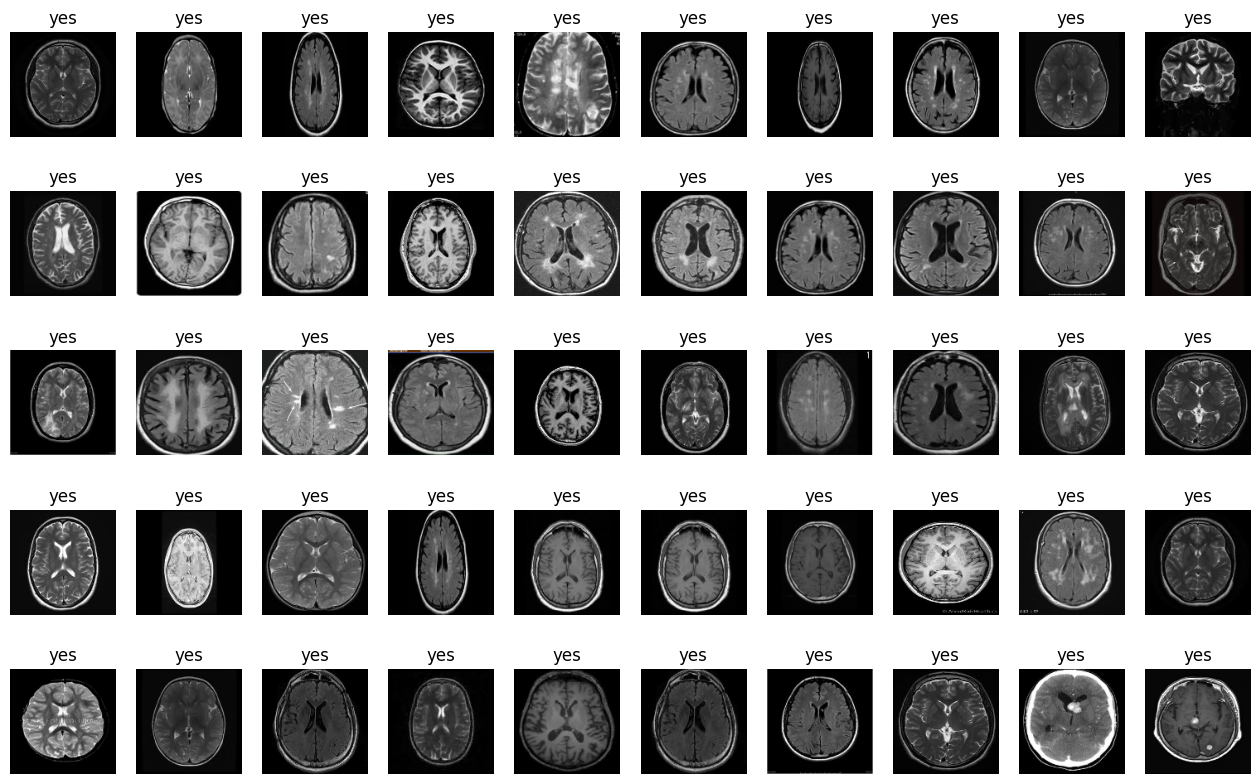

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure()
plt.figure(figsize=(16,10))

num_of_images = 50

classes = ["yes", "no"]

for index in range(1, num_of_images + 1):
    class_names = classes[y[index]]
    plt.subplot(5, 10, index).set_title(f'{class_names}')
    plt.axis('off')
    plt.imshow(X[index], cmap='gray_r')

In [ ]:
X = X.astype('float32')

In [ ]:
img_rows = X[0].shape[0]
img_cols = X[0].shape[1]

In [ ]:
input_shape = (img_rows, img_cols, 3)

X /= 255.0
y = to_categorical(y, num_classes=2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [ ]:
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to add noise
def gaussian_denoise(images, kernel_size=(5, 5), sigma=1.0):
    denoised_images = []
    for img in images:
        if img.dtype in [np.float32, np.float64]:
            img = (img * 255).astype(np.uint8)
        denoised_img = cv2.GaussianBlur(img, kernel_size, sigma)
        denoised_images.append(denoised_img)
    return np.array(denoised_images) / 255.0

# Denoise the training and testing data
X_train_denoised = gaussian_denoise(X_train)
X_test_denoised = gaussian_denoise(X_test)

# Define input shape
input_shape = (128, 128, 3)

# Load the InceptionV3 model without the fully connected layers
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in inception.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained InceptionV3
input_img = Input(shape=input_shape)
x = inception(input_img)
x = GlobalAveragePooling2D()(x)  # Global Average Pooling to reduce dimensions
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(2, activation='softmax')(x)  # Change the output units to match your classes

# Create and compile the model
model = Model(input_img, output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
history = model.fit(datagen.flow(X_train_noisy, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_test_noisy, y_test),
                    callbacks=[reduce_lr])

# Print model summary
print(model.summary())

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(X_test_noisy, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6023 - loss: 1.3459 - val_accuracy: 0.6078 - val_loss: 0.7985 - learning_rate: 0.0010
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5862 - loss: 1.1545 - val_accuracy: 0.7647 - val_loss: 0.5350 - learning_rate: 0.0010
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5628 - loss: 1.2667 - val_accuracy: 0.7647 - val_loss: 0.4753 - learning_rate: 0.0010
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6464 - loss: 0.9354 - val_accuracy: 0.9020 - val_loss: 0.3407 - learning_rate: 0.0010
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6774 - loss: 0.8307 - val_accuracy: 0.9020 - val_loss: 0.3267 - learning_rate: 0.0010
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6705 - loss: 0.9567 - val_accuracy: 0.8627 - val_loss: 0.4138 - learning_rate: 0.0010
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,815,080 (83.22 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 8,198 (32.03 KB)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - accuracy: 0.9400 - loss: 0.2949
Test accuracy: 94.12%


1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


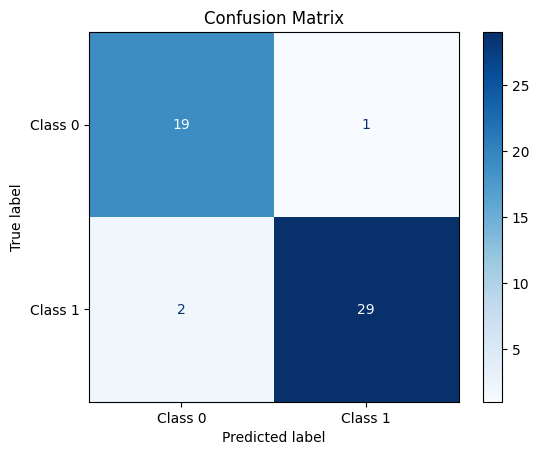

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions
y_pred = model.predict(X_test_noisy)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])  # Adjust labels as needed
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
